<a href="https://colab.research.google.com/github/rumelay/Aiffel_quest_cr/blob/main/imagepr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Stable Diffusion 설치
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 108.8 MB/s eta 0:00:00


In [ ]:
# 메모리 삭제
# torch.cuda.empty_cache()

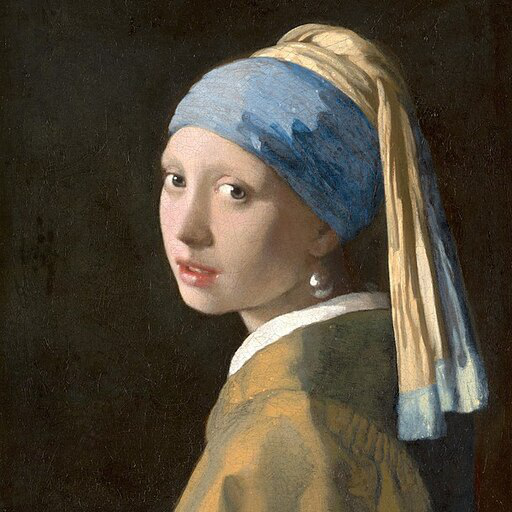

In [9]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

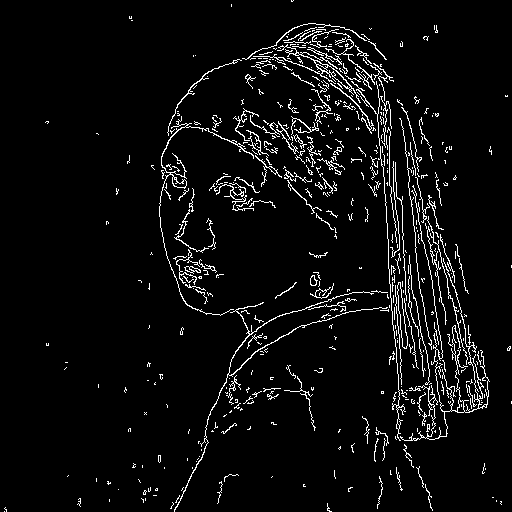

In [10]:
import cv2
from PIL import Image
import numpy as np

# 이미지를 NumPy 배열로 변환합니다.
image = np.array(image)

# threshold를 지정합니다.
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다.
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다.

canny_image

In [11]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

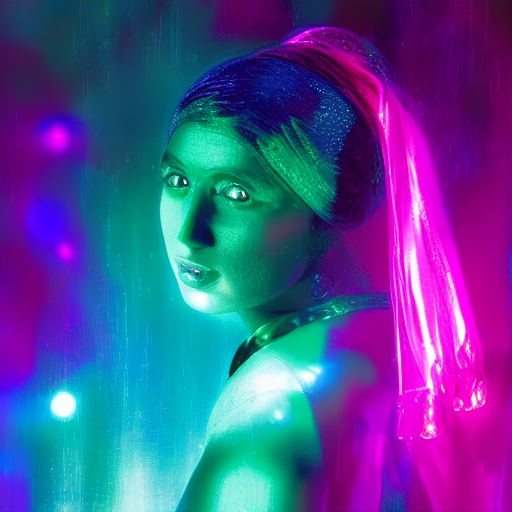

In [12]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
generator = torch.manual_seed(0)

# 이미지를 생성합니다.
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights",
    num_inference_steps=20,
    generator=generator,
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다.
canny_image.save("aiffel/canny_image.png")

# 생성된 이미지를 출력합니다.
canny_image

  0%|          | 0/70 [00:00<?, ?it/s]

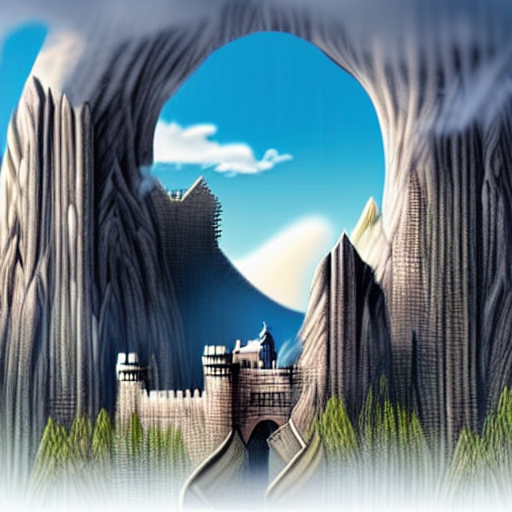

In [13]:
# ControlNet 기반 이미지 생성 코드
# 프롬프트와 부정적인 프롬프트 설정
prompt = "A magnificent castle on a mountain surrounded by clouds, fantasy art, highly detailed, epic lighting"
negative_prompt = "low quality, blurry, distorted, low resolution, poorly lit"

# 하이퍼파라미터 설정
num_inference_steps = 70  # 고해상도를 위해 추론 횟수 증가
guidance_scale = 8.0  # 프롬프트와 더욱 근접한 이미지 생성
controlnet_conditioning_scale = 0.8  # ControlNet 조건 강도를 조절

# 이미지 생성
generator = torch.manual_seed(1234)  # 동일한 결과를 재현하기 위해 seed 설정
generated_image = canny_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다.
generated_image.save("aiffel/generated_image_customized.png")

# 생성된 이미지를 출력합니다.
generated_image

In [14]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

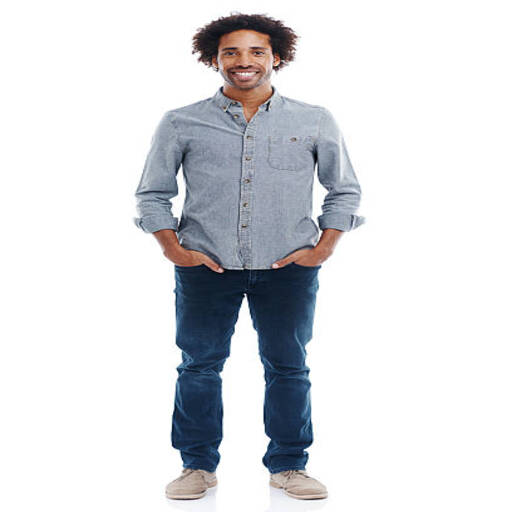

In [15]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

cuda


/usr/local/lib/python3.10/dist-packages/controlnet_aux/open_pose/body.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.transfer(self.model, torch.load(

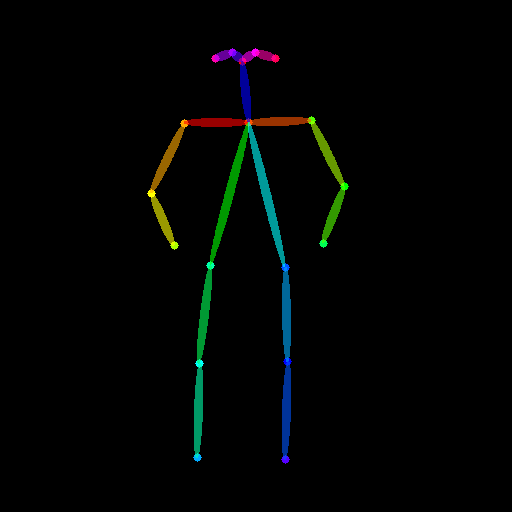

In [16]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

In [17]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

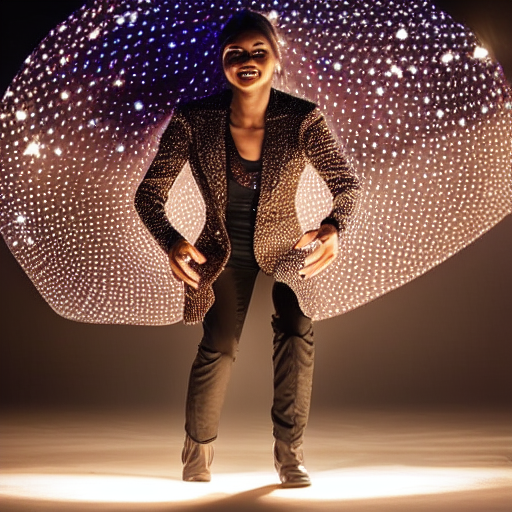

In [18]:
from diffusers import UniPCMultistepScheduler

# OpenPose 파이프라인 설정
openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 설정합니다.
generator = torch.manual_seed(42)

# 프롬프트와 부정적인 프롬프트 설정
prompt = "A person dancing gracefully under spotlights, detailed, artistic, elegant"
negative_prompt = "blurry, low quality, distorted, unrealistic"

# 이미지를 생성합니다.
openpose_image1 = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,  # 추론 단계
    guidance_scale=7.5,  # 프롬프트 일치를 위한 scale
    image=openpose_image,
    generator=generator,
).images[0]

# 생성된 이미지를 출력합니다.
openpose_image1

  0%|          | 0/75 [00:00<?, ?it/s]

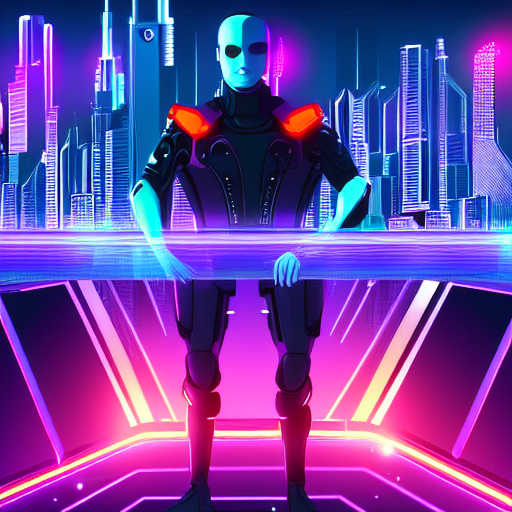

In [19]:
# 프롬프트 작성 및 하이퍼파라미터 조정
prompt = "A futuristic cityscape at night with neon lights, detailed, vibrant colors, cyberpunk style"
negative_prompt = "blurry, low quality, less detailed, grainy"

# 하이퍼파라미터 설정
num_inference_steps = 75  # 추론 단계를 늘려 이미지 품질 개선
guidance_scale = 10.0  # 프롬프트에 더 집중하도록 유도
controlnet_conditioning_scale = 1.0  # ControlNet 조건 강도를 최대화

# 이미지 생성
generator = torch.manual_seed(101)  # 재현성을 위한 시드 설정
generated_image = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    image=openpose_image,
    generator=generator
).images[0]

# 생성된 이미지를 출력합니다.
generated_image

In [22]:
from diffusers.utils import load_image
from PIL import Image
import cv2
import numpy as np

# 이미지를 불러오세요.
canny_image = load_image("aiffel/canny_image.png")  # [[YOUR CODE]]
canny_image = canny_image.convert("L")  # 그레이스케일로 변환  # [[YOUR CODE]]

# threshold를 지정합니다.
low_threshold = 100  # [[YOUR CODE]]
high_threshold = 200  # [[YOUR CODE]]

# 이미지를 NumPy 배열로 변환합니다.
canny_image = np.array(canny_image)  # [[YOUR CODE]]

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다.
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다.
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)  # [[YOUR CODE]]
canny_image = canny_image[:, :, None]  # [[YOUR CODE]]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)  # [[YOUR CODE]]
canny_image = Image.fromarray(canny_image)  # [[YOUR CODE]]

In [24]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image

# Q. 아래의 코드를 작성해 주세요.
# 이미지를 불러옵니다.
openpose_image = load_image("aiffel/canny_image.png")  # 불러올 이미지 경로를 지정하세요.

# OpenposeDetector를 사용하여 인체 자세를 검출합니다.
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose_image = openpose(openpose_image)

cuda


/usr/local/lib/python3.10/dist-packages/controlnet_aux/open_pose/body.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.transfer(self.model, torch.load(

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

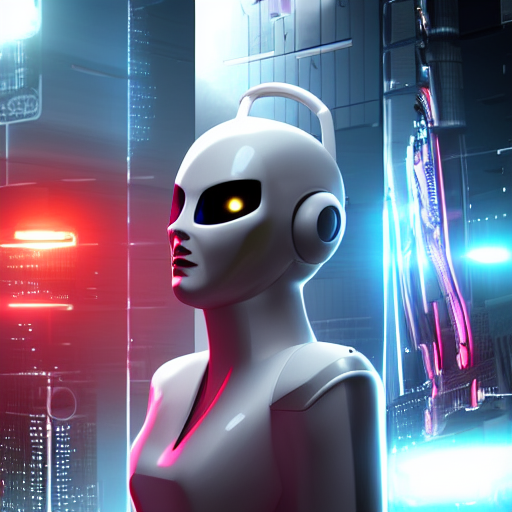

In [25]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler

# Q. 코드를 작성해 보세요.
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다.
controlnet_canny = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
controlnet_openpose = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
controlnets = [controlnet_openpose, controlnet_canny]

# 리스트 controlnets를 파이프라인으로 전달합니다.
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnets,
    torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다.
prompt = "A futuristic robot walking in a city at night, cyberpunk style, detailed, cinematic lighting"
negative_prompt = "blurry, low quality, poorly detailed, distorted"

# seed를 지정합니다.
generator = torch.manual_seed(123)

images = [openpose_image, canny_image]

# 이미지를 생성합니다.
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,
    guidance_scale=7.5,
    image=images,
    generator=generator
).images[0]

# 생성된 이미지를 저장합니다.
image.save("aiffel/multi_controlnet_output.png")

# 생성된 이미지를 출력합니다.
image

In [26]:
print("생성한 이미지를 올린 곳은 Github 입니다.")

생성한 이미지를 올린 곳은 Github 입니다.
